In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
from sklearn.metrics import adjusted_rand_score
import backbone
import networkx as nx
import copy
%matplotlib inline

In [203]:
years = list(map(str,range(1999,2018)))
with open('../trade_clusters/EU_countries.json') as f:
    countries = json.load(f)['results']
countries_id = [c['id'] for c in countries]
countries_name = {c['id']:c['text'] for c in countries}

In [204]:
files = {y: glob.glob('../../data/comtrade/Export_data_yearly/AG2/{}/Export_{}_*_*.csv'.format(y,y)) for y in years}
files = {y: [f for f in files[y] if f.split('_')[-2] in countries_id] for y in years}
files = {y: [f for f in files[y] if f.split('_')[-1][:-4] in countries_id] for y in years}

In [205]:
[(y,len(files[y])) for y in years]

[('1999', 752),
 ('2000', 754),
 ('2001', 754),
 ('2002', 755),
 ('2003', 754),
 ('2004', 756),
 ('2005', 755),
 ('2006', 755),
 ('2007', 754),
 ('2008', 754),
 ('2009', 756),
 ('2010', 756),
 ('2011', 754),
 ('2012', 753),
 ('2013', 755),
 ('2014', 756),
 ('2015', 756),
 ('2016', 756),
 ('2017', 756)]

In [206]:
year = '2017'

In [207]:
data = [pd.read_csv(f) for f in files[year]]
for i in range(len(data)):
    data[i] = data[i][['Year',
                       'Partner',
                       'Partner Code',
                       'Reporter',
                       'Reporter Code',
                       'Commodity',
                       'Commodity Code',
                       'Trade Value (US$)']]
data = pd.concat(data)

In [208]:
multilayer_100 = data[['Commodity Code', 'Partner Code', 'Reporter Code','Trade Value (US$)']]
multilayer_100.columns = ['SITC', 'Partner Code', 'Reporter Code', 'export']

In [209]:
hs_to_sitc = pd.read_csv('../../data/comtrade/HStoSITC.csv',sep='\t',dtype={'From HS 2017' : str, 'To SITC Rev. 4':str})
hs_to_sitc['From HS 2017'] = hs_to_sitc['From HS 2017'].apply(lambda x: int(x[:2]))
hs_to_sitc['To SITC Rev. 4'] = hs_to_sitc['To SITC Rev. 4'].apply(lambda x: int(x[:1]))
hs_to_sitc = dict(np.array(hs_to_sitc))

In [210]:
data['SITC'] = data['Commodity Code'].map(hs_to_sitc)


In [211]:
sitc_names = {0 : 'Food and live animals',
              1 : 'Beverages and tobacco',
              2 : 'Crude materials, inedible, except fuels',
              3 : 'Mineral fuels, lubricants and related materials',
              4 : 'Animal and vegetable oils, fats and waxes',
              5 : 'Chemicals and related products, n.e.s.',
              6 : 'Manufactured goods',
              7 : 'Machinery and transport equipment',
              8 : 'Miscellaneous manufactured articles',
              9 : 'Commodities and transactions not classified elsewhere'}

In [212]:
data['SITC_name'] = data['SITC'].map(sitc_names)

In [213]:
data.head()

,Year,Partner,Partner Code,Reporter,Reporter Code,Commodity,Commodity Code,Trade Value (US$),SITC,SITC_name
0,2017,Slovenia,705,Croatia,191,Animals; live,1,6429801,0,Food and live animals
1,2017,Slovenia,705,Croatia,191,Meat and edible meat offal,2,33105698,0,Food and live animals
2,2017,Slovenia,705,Croatia,191,"Fish and crustaceans, molluscs and other aquat...",3,19581895,0,Food and live animals
3,2017,Slovenia,705,Croatia,191,Dairy produce; birds' eggs; natural honey; edi...,4,24740726,0,Food and live animals
4,2017,Slovenia,705,Croatia,191,Animal originated products; not elsewhere spec...,5,968436,2,"Crude materials, inedible, except fuels"


In [214]:
multilayer = data.groupby(['SITC', 'Partner Code', 'Reporter Code', ])['Trade Value (US$)'].sum().reset_index()
multilayer.columns = ['SITC', 'Partner Code', 'Reporter Code', 'export']
multilayer.head()

,SITC,Partner Code,Reporter Code,export
0,0,40,56,304951084
1,0,40,100,38562103
2,0,40,191,85694913
3,0,40,196,8960827
4,0,40,203,372037839


# Lista di cose da fare
* community detection per layer
* serrano disparity filter prima e dopo community
* misure su multilayer:
  * attivita' dei nodi

# Disparity Filter

In [215]:
a = nx.Graph()

In [216]:
commodities = set(multilayer.SITC)
comm_dfs = []


for comm in commodities:
    
    multi_comm = multilayer.query('SITC=={}'.format(comm))
    G = nx.Graph()
    for a,b,w in np.array(multi_comm[['Partner Code','Reporter Code','export']]):
        G.add_edge(a,b,weight=w)
        
    G1 = backbone.disparity_filter(G,weight='weight')
    multi_comm['alpha'] = [G1.edges[a,b]['alpha'] for a,b in np.array(multi_comm[['Partner Code','Reporter Code']])]
    comm_dfs.append(multi_comm)
    


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [217]:
multilayer = pd.concat(comm_dfs,ignore_index=1)

In [231]:
edges_df = copy.copy(multilayer)

edges_df.columns = ['network_id','from_id','to_id','export_value','alpha']
edges_df['network_name'] = edges_df['network_id'].map(sitc_names)

edges_df.to_csv('arcs_multilayer.csv',index=None)

# Misure di Fede

In [240]:
multi = multilayer
n_layer = len(set(multi.SITC))
direction = 'Reporter'


overlap_degree = multi.groupby('{} Code'.format(direction))['export'].sum().reset_index()
overlap_degree.columns = ['{} Code'.format(direction), 'aggr_export']

layer_degree = multi.groupby(['{} Code'.format(direction),'SITC'])['export'].sum().reset_index()

part_df = pd.merge(layer_degree[['{} Code'.format(direction),'SITC','export']],overlap_degree,on='{} Code'.format(direction))

part_df['ratio_exp'] = (part_df.export/part_df.aggr_export)**2

partecipation_coeff = ((n_layer/(n_layer - 1.))*(1 - part_df.groupby('{} Code'.format(direction))['ratio_exp'].sum())).reset_index()

summary_df = pd.merge(overlap_degree,partecipation_coeff,on='{} Code'.format(direction))
summary_df.columns = ['reporter','aggr_exp','part_coef']
summary_df.reporter = summary_df.reporter.apply(lambda x: countries_name[str(x)])

#summary_df.aggr_exp = (summary_df.aggr_exp - summary_df.aggr_exp.mean())/summary_df.aggr_exp.std()



y = (summary_df.aggr_exp).tolist()
x = summary_df.part_coef.tolist()

export_df = summary_df

In [221]:
#(97/96)*(1-((part_df[part_df['Reporter Code']==703]['ratio_exp'])**2).sum())

In [222]:
#((part_df[part_df['Reporter Code']==703]['ratio_exp'])**2).sum()

In [223]:
(part_df[part_df['{} Code'.format(direction)]==703]).sort_values('ratio_exp',ascending=0)

,Partner Code,SITC,export,aggr_export,ratio_exp
237,703,7,25497021223,57415850014,0.197204
236,703,6,10706212018,57415850014,0.034770
238,703,8,9063293655,57415850014,0.024918
230,703,0,4430698875,57415850014,0.005955
235,703,5,3758922822,57415850014,0.004286
233,703,3,2198986899,57415850014,0.001467
232,703,2,780312397,57415850014,0.000185
239,703,9,620649996,57415850014,0.000117
234,703,4,213886548,57415850014,0.000014
231,703,1,145865581,57415850014,0.000006


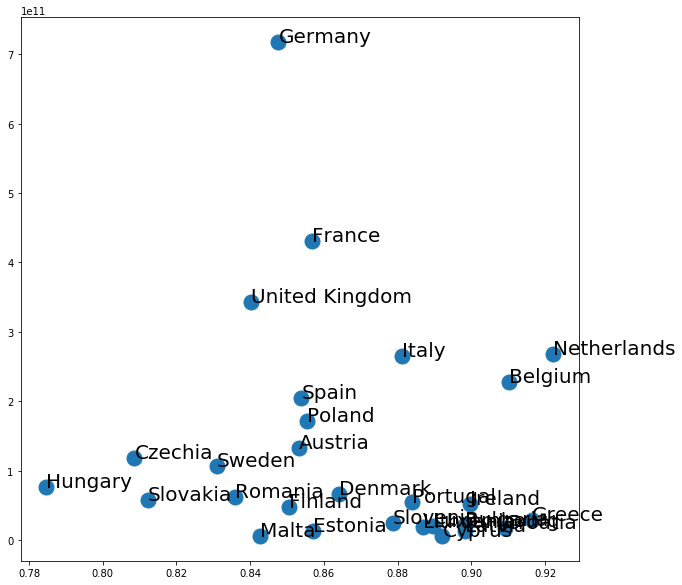

In [224]:
plt.figure(figsize=(10,10))

plt.plot(x,y,'o',ms=15)
text = [plt.text(x,y,s,fontsize=20) for s,y,x in np.array(summary_df)]

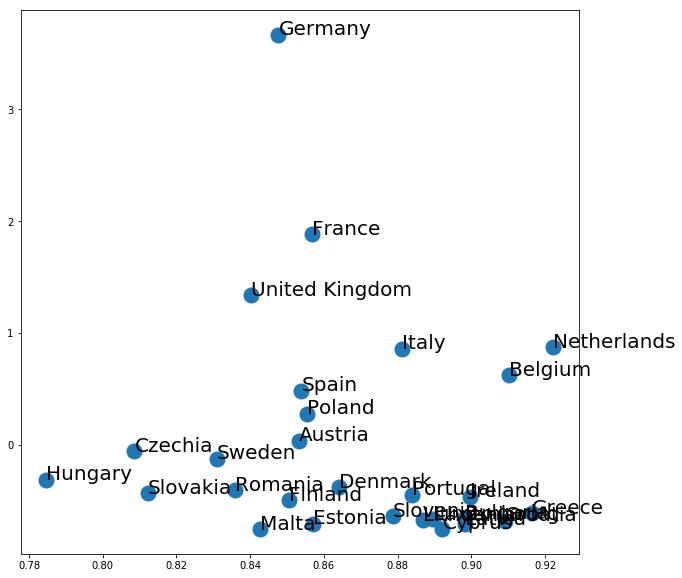

In [163]:
plt.figure(figsize=(10,10))

plt.plot(x,y,'o',ms=15)
text = [plt.text(x,y,s,fontsize=20) for s,y,x in np.array(summary_df)]

In [242]:
export_df.columns = ['id','export_overlap','export_part']
import_df.columns = ['id','import_overlap','import_part']


In [243]:
# code to add other information
partners = data[['Partner Code', 'Partner']].drop_duplicates()
reporters = data[['Reporter Code', 'Reporter']].drop_duplicates()
multilayer_new = pd.merge(multilayer, partners, on='Partner Code', validate='many_to_one')
multilayer_new = pd.merge(multilayer_new, reporters, on='Reporter Code', validate='many_to_one')
multilayer_new['SITC_name'] = multilayer_new['SITC'].map(sitc_names)
multilayer_new = multilayer_new[['Partner Code', 'Partner']].drop_duplicates()
multilayer_new.columns = ['id','name']
multilayer_new.index = range(len(multilayer_new))
multilayer_new = df.merge(export_df,on='id')
multilayer_new = df.merge(import_df,on='id')

NameError: name 'df' is not defined